In [1]:
using Revise
using Pkg
Pkg.activate("..")
Pkg.instantiate()

  Activating project at `~/syndr/Wouter/Onderzoek/Projecten/tue/preds2actuator/preds-not-commands`


In [8]:
using LinearAlgebra 
using Distributions
using RxInfer
using Plots
default(label="", grid=false, linewidth=3, margin=15Plots.pt)

includet("../Muscles.jl"); using .Muscles

### Simulate muscle response

In [50]:
T = 100
Δt = 0.01  
tsteps = range(0, step=Δt, length=T)

x_0 = [0.5, 0.5]
muscles = MusclePair(init_state=x_0, mnoise_sd=1e-3, Δt=Δt)

muscles_x = [x_0]
muscles_u = []
muscles_y = []

inputs = [[NormalMeanVariance(0.2, 1.0), NormalMeanVariance(0.8, 1.0)] for t in tsteps[2:end]]

for (k,inp) in enumerate(inputs)
    
    step!(muscles, inp)    
    
    push!(muscles_u, muscles.prediction)
    push!(muscles_y, muscles.sensation)
    push!(muscles_x, muscles.states)
end

┌ Info: Saved animation to /tmp/jl_khUR4pO5e1.gif
└ @ Plots /home/wmkouw/.julia/packages/Plots/sxUvK/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_khUR4pO5e1.gif")
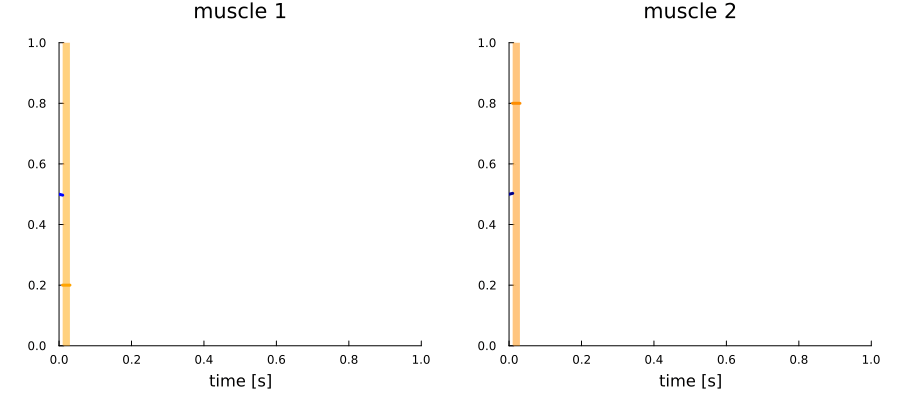

In [51]:
anim = @animate for t in 2:T-3
    
    p11 = plot( xlabel="time [s]", title="muscle 1", xlims=(0, 1), ylims=(0,1))
    plot!(tsteps[t:t+2], [mean.(muscles_u[i])[1] for i in t:t+2], ribbon=[std.(muscles_u[i])[1] for i in t:t+2], color="orange")
    plot!(tsteps[1:t], [muscles_x[i][1] for i in 1:t], color="blue")
    
    p12 = plot( xlabel="time [s]", title="muscle 2", xlims=(0, 1), ylims=(0,1))
    plot!(tsteps[t:t+2], [mean.(muscles_u[i])[2] for i in t:t+2], ribbon=[std.(muscles_u[i])[2] for i in t:t+2], color="darkorange")
    plot!(tsteps[1:t], [muscles_x[i][2] for i in 1:t], color="darkblue")

    plot(p11, p12, layout=(1,2), size=(900,400))

end
gif(anim, fps=15)

In [5]:
p11 = plot(xlabel="time [s]", ylabel="predictions")
plot!(tsteps[2:end], mean.(muscle_u), ribbon=std.(muscle_u), color="orange")

p12 = plot(xlabel="time [s]", ylabel="muscle state", ylims=(0,1), yticks=([0., 1.], ["relaxed", "contracted"]))
plot!(tsteps, muscle_x, color="blue")

plot(p11,p12, layout=(1,2), size=(900,400))

### Single planned trajectory

In [6]:
@model function planning_agent(T::Int, λ::Real, τ::Real)
  
    # States
    x = randomvar(T)

    # State prior
    m_0 = datavar(Float64)
    p_0 = datavar(Float64)
    x_0 ~ NormalMeanPrecision(m_0, p_0)
    
    # First state
    x[1] ~ NormalMeanPrecision(x_0,  λ)

    # Observation
    m_1 = datavar(Float64)
    p_1 = datavar(Float64)
    y_1 ~ NormalMeanPrecision(m_1, p_1)
    y_1 ~ NormalMeanPrecision(x[1], τ)
    
    # Goal priors
    y = randomvar(T-1)
    m_star = datavar(Float64)
    p_star = datavar(Float64)

    for t in 1:(T-1)

        # State transition
        x[t+1] ~ NormalMeanPrecision(x[t], λ)
        y[t]   ~ NormalMeanPrecision(x[t+1], τ)

        # Goal prior
        y[t] ~ NormalMeanPrecision(m_star, p_star)

    end
end

T = 4
m_star = 0.5
p_star = 1e1

m_1 = rand()
p_1 = 1e3

m_0 = 0.0
p_0 = 1e0

# Noise precisions
λ = 1e1
τ = 1e3

pp = inference(
    model = planning_agent(T, λ, τ),
    data = (m_1=m_1, p_1=p_1, m_0=m_0, p_0=p_0, m_star=m_star, p_star=p_star),
)

x_m = [m_0; mean.(pp.posteriors[:x])]
x_v = [1/p_0; var.(pp.posteriors[:x])];

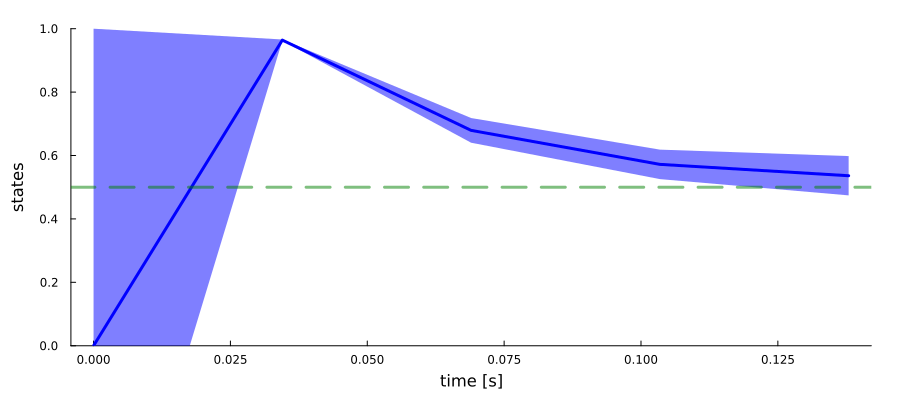

In [7]:
plot(xlabel="time [s]", ylabel="states", ylims=(0,1), size=(900,400))
plot!(tsteps[1:T+1], x_m, ribbon=x_v, color="blue")
hline!([m_star], color="green", linestyle=:dash, alpha=0.5)

### Reaction to goal priors

In [8]:
N = 50
T = 2
Δt = 1.0
tsteps = range(0, step=Δt, length=N)

# Noise precisions
λ = 1e3
τ = 5

# Initialize muscle
init_state = 0.1
muscle = Muscle(init_state=init_state, mnoise_sd=sqrt(inv(τ)), Δt=Δt)

# State prior
m_0 = 0.1
p_0 = 1e1

# Goal prior
m_star = [0.1*ones(10); 0.8*ones(N-10)]
p_star = 1e3*ones(N)

sensations  = []
predictions = [NormalMeanPrecision(0.0, 5.0)]
states      = [NormalMeanPrecision(m_0, p_0)]

for k in 1:N-1

    # Send prediction to muscle
    step!(muscle, predictions[k])

    # Extract parameters of sensation
    m_1, p_1 = mean_precision(muscle.sensation)
    push!(sensations, muscle.sensation)

    # Update prediction towards muscle
    pp = inference(
        model = planning_agent(T, λ, τ),
        data = (m_1=m_1, p_1=p_1, m_0=m_0, p_0=p_0, m_star=m_star[k], p_star=p_star[k]),
    )    

    # Extract prediction for time k+1
    push!(predictions, pp.posteriors[:x][2])

    # Update state prior
    m_0, p_0 = mean_precision(pp.posteriors[:x][1])
    push!(states, pp.posteriors[:x][1])
end

┌ Info: Saved animation to /tmp/jl_mjG3enkjmZ.gif
└ @ Plots /home/wmkouw/.julia/packages/Plots/sxUvK/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_mjG3enkjmZ.gif")
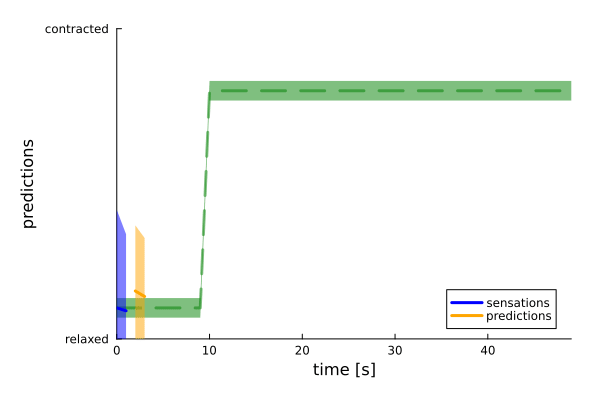

In [15]:
anim = @animate for k in 2:N-T
    
    plot(xlabel="time [s]", ylabel="predictions", xlims=(0,tsteps[end]), ylims=(0,1), yticks=([0., 1.], ["relaxed", "contracted"]))
    plot!(tsteps, m_star, ribbon=sqrt.(inv.(p_star)), color="green", linestyle=:dash, alpha=0.5)
    plot!(tsteps[1:k], mean.(states[1:k]), ribbon=std.(states[1:k]), color="blue", label="sensations")
    plot!(tsteps[k+1:k+T], mean.(predictions[k+1:k+T]), ribbon=std.(predictions[k+1:k+T]), color="orange", label="predictions")
    
    
end
gif(anim, fps=10)

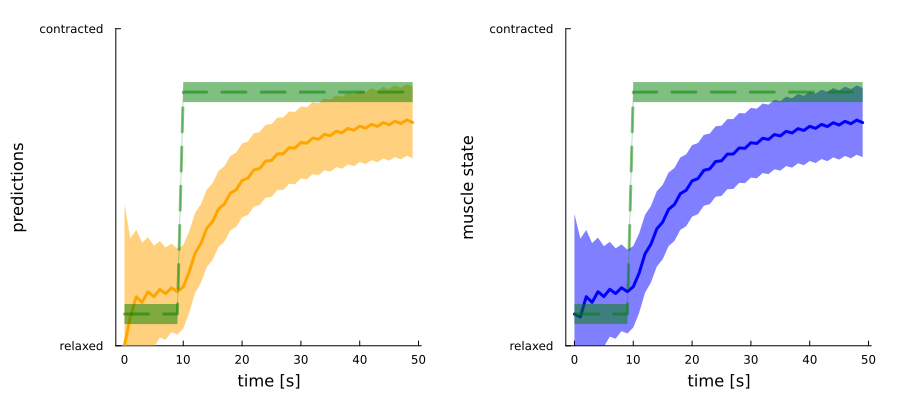

In [10]:
p21 = plot(xlabel="time [s]", ylabel="predictions", ylims=(0,1), yticks=([0., 1.], ["relaxed", "contracted"]))
plot!(tsteps, mean.(predictions), ribbon=std.(predictions), color="orange")
plot!(tsteps, m_star, ribbon=sqrt.(inv.(p_star)), color="green", linestyle=:dash, alpha=0.5)

p22 = plot(xlabel="time [s]", ylabel="muscle state", ylims=(0,1), yticks=([0., 1.], ["relaxed", "contracted"]))
plot!(tsteps, mean.(states), ribbon=std.(states), color="blue")
plot!(tsteps, m_star, ribbon=sqrt.(inv.(p_star)), color="green", linestyle=:dash, alpha=0.5)

plot(p21,p22, layout=(1,2), size=(900,400))

In [14]:
savefig("figures/smuscle-response.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/preds2actuator/preds-not-commands/single-muscle/figures/smuscle-response.png"